# COMPUTATIONAL PROJECT 2

### Importing Necessary Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, stats
from IPython.display import display, HTML
import seaborn as sns

# PART 1

In this section, we analyze the dataset "codeforces_standings.csv" which contains two columns:

- **CF Handle:** The Codeforces (A competitive programming platform) handle of a participants in IIT Hyderabad.
- **Rating:** The numerical rating of the user.

Our objectives are:
1. Perform an exploratory data analysis (EDA) of the dataset, including summary statistics and visualizations.
2. Model the data as the Gamma distribution with unknown parameters a and b, and estimate the parameters using MoM and MLE.
3. Model the data as coming from a Normal distribution with an unknown mean and variance and compute the 95% confidence interval for the variance 


## EDA

In [7]:
# defining the plotting parameters, styles
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

Loading the dataset 

In [9]:
df = pd.read_csv("codeforces_standings.csv")
df.head()

,Handle,Rating
0,weirdflexbutok,2189
1,goats_9,2124
2,hemanth6,2045
3,RandomBee,2012
4,SaltyDonut,1990


Lets look at some analytics

In [11]:
df['Rating'].describe()

count     118.000000
mean     1245.661017
std       354.881616
min       346.000000
25%      1011.500000
50%      1200.500000
75%      1460.750000
max      2189.000000
Name: Rating, dtype: float64

Lets visualize the ratings through a histogram

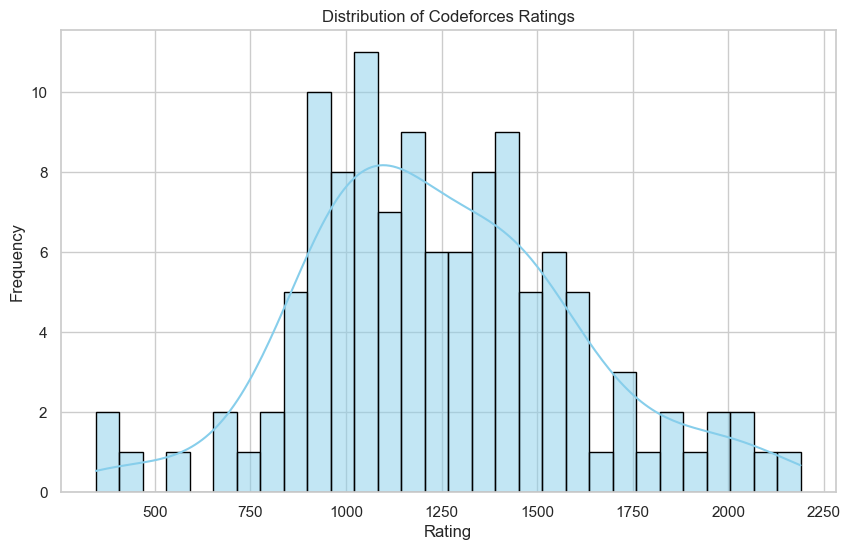

In [13]:
plt.figure(figsize=(10,6))
sns.histplot(df['Rating'], kde=True, bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Codeforces Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

## Gamma Parameter Estimaton


We assume that the "rating" variable follows a Gamma distribution. The probability density function (PDF) for a Gamma distribution, parameterized by a shape parameter $a$ and a scale parameter $b$, is given by:

$$
f(x; a, b) = \frac{1}{\Gamma(a)\,b^a} \, x^{a-1} \, e^{-x/b}, \quad \text{for } x > 0, \, a > 0, \, b > 0.
$$

In this parameterization:
- **$a$ (shape parameter):** Determines the form (or skewness) of the distribution.
- **$b$ (scale parameter):** Stretches or compresses the distribution along the $x$-axis.We assume that the "rating" variable follows a Gamma distribution. 

### Method of Moments

In the method of moments, we equate the sample moments (calculated from data) to the theoretical moments of the distribution and solve for the parameters.

Let:
- $\bar{x}$ be the sample mean.
- $s^2$ be the sample variance (using the unbiased estimator).

Since we have:
- Theoretical mean: $\mu = a \cdot b$
- Theoretical variance: $\sigma^2 = a \cdot b^2$

We set these equal to the sample moments:
1. $\bar{x} = a \cdot b$
2. $s^2 = a \cdot b^2$

From equation (1), solving for $b$, we get:
$$
b = \frac{\bar{x}}{a}.
$$

Substitute this expression into equation (2):
$$
s^2 = a \cdot \left(\frac{\bar{x}}{a}\right)^2 = a \cdot \frac{\bar{x}^2}{a^2} = \frac{\bar{x}^2}{a}.
$$

Now, solving for $a$, we have:
$$
a = \frac{\bar{x}^2}{s^2}.
$$

Once $a$ is estimated, we substitute back into $b = \bar{x} / a$:
$$
b = \frac{s^2}{\bar{x}}.
$$

Thus, the Method of Moments estimates are:
- **$a_{MoM} = \frac{\bar{x}^2}{s^2}$**
- **$b_{MoM} = \frac{s^2}{\bar{x}}$**

In [18]:
data = df['Rating']

# Sample moments
mean_data = np.mean(data)
var_data = np.var(data, ddof=1)  

# Method of Moments estimates
a_mom = mean_data**2 / var_data
b_mom = var_data / mean_data

print("Method of Moments estimates:")
print("a (shape) =", a_mom)
print("b (scale) =", b_mom)

Method of Moments estimates:
a (shape) = 12.32062512814628
b (scale) = 101.10371868254143


### Maximum Likelihood Estimator

#### With Libraries

We use `scipy.stats.gamma.fit` to estimate $a$ and $b$.

In [22]:
from scipy import stats

# The gamma.fit function returns (shape, loc, scale). We fix loc=0.
a_mle_lib, loc, b_mle_lib = stats.gamma.fit(data, floc=0)
print("\nMaximum Likelihood estimates (with loc fixed to 0):")
print("a (shape) =", a_mle_lib)
print("b (scale) =", b_mle_lib)


Maximum Likelihood estimates (with loc fixed to 0):
a (shape) = 11.41784489864997
b (scale) = 109.09773499344328


#### Through Newton-Raphson Method

Given a dataset $x_1,\, x_2,\, \dots,\, x_n$, let the sample mean be $\bar{x}$ and the sample variance be $s^2$. In maximum likelihood estimation, we write the log-likelihood as

$$
\ell(a,b) = \sum_{i=1}^n \ln f(x_i; a, b)
= \sum_{i=1}^n \Bigl[ (a-1)\ln x_i - \frac{x_i}{b} - a\ln b - \ln \Gamma(a) \Bigr].
$$

Differentiating with respect to $b$ gives the MLE for $b$:

$$
\hat{b} = \frac{\bar{x}}{a}.
$$

Substituting $b=\bar{x}/a$ back into the log-likelihood and differentiating with respect to $a$ leads (using properties of the Gamma function) to the following equation:

$$
\ln a - \psi(a) = \ln \bar{x} - \overline{\ln x},
$$

where $\psi(a)$ is the digamma function, and

$$
s = \ln \bar{x} - \overline{\ln x}.
$$

Our goal is to solve for $a$ in the equation

$$
g(a) = \ln a - \psi(a) - s = 0.
$$

Since there is no closed-form solution for $a$, we will use the Newton–Raphson iteration method. The steps are as follows:

1. **Initial guess:** Use the method of moments estimate:
   $$ a_0 = \frac{\bar{x}^2}{s^2}. $$
2. **Newton–Raphson update:** 
   $$ a_{\text{new}} = a_{\text{old}} - \frac{g(a_{\text{old}})}{g'(a_{\text{old}})}, $$
   where the derivative is given by
   $$ g'(a) = \frac{1}{a} - \psi^{(1)}(a), $$
   and $\psi^{(1)}(a)$ is the trigamma function.

Once we obtain the MLE $\hat{a}$, the scale parameter is computed as

$$
\hat{b} = \frac{\bar{x}}{\hat{a}}.
$$

Below, we will implement this method, including a plot of the function $g(a)$ to visualize its zero crossing.

In [25]:
data = df['Rating'].values

# Compute sample statistics
mean_data = np.mean(data)
log_mean_data = np.mean(np.log(data))
s_val = np.log(mean_data) - log_mean_data  # s = ln(mean) - mean(ln(data))

print("Sample Mean:", mean_data)
print("Mean of log(data):", log_mean_data)
print("s (ln(mean) - mean(ln(data))):", s_val)

Sample Mean: 1245.6610169491526
Mean of log(data): 7.082991772604782
s (ln(mean) - mean(ln(data))): 0.044429832705239036


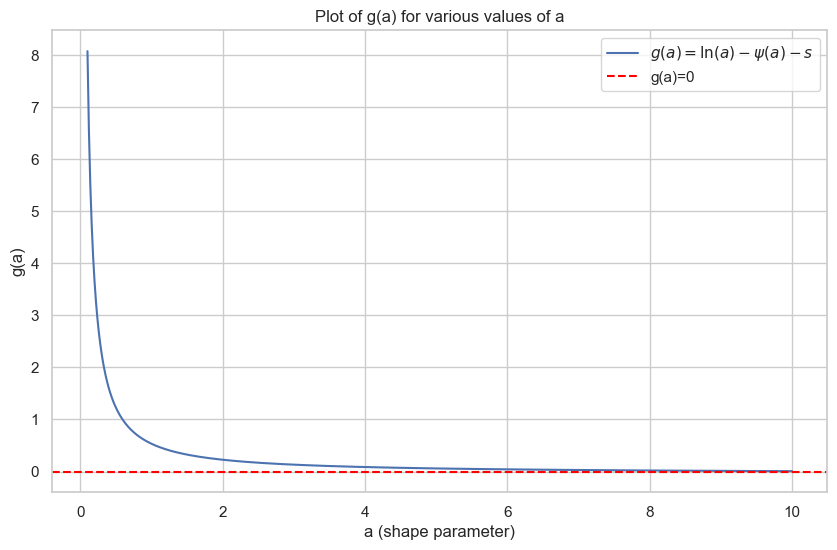

In [26]:
from scipy.special import psi, polygamma

# Defining the function g(a) = ln(a) - psi(a) - s
def g(a, s):
    return np.log(a) - psi(a) - s

# Defining the derivative g'(a) = 1/a - trigamma(a)
def g_prime(a):
    return 1 / a - polygamma(1, a)


a_values = np.linspace(0.1, 10, 500)
g_values = g(a_values, s_val)

plt.plot(a_values, g_values, label=r'$g(a) = \ln(a) - \psi(a) - s$')
plt.axhline(0, color='red', linestyle='--', label='g(a)=0')
plt.xlabel("a (shape parameter)")
plt.ylabel("g(a)")
plt.title("Plot of g(a) for various values of a")
plt.legend()
plt.show()

In [27]:
# Newton-Raphson method to solve for a in g(a)=0
tol = 1e-8
max_iter = 100

# Initial guess for a using the method of moments: a0 = (mean)^2 / variance
var_data = np.var(data, ddof=1)
a_guess = mean_data**2 / var_data

print("Initial guess for a (Method of Moments):", a_guess)

a_old = a_guess
for i in range(max_iter):
    ga = g(a_old, s_val)
    ga_prime = g_prime(a_old)
    a_new = a_old - ga / ga_prime
    if np.abs(a_new - a_old) < tol:
        break
    a_old = a_new

a_mle_newt = a_new
b_mle_newt = mean_data / a_mle_newt

print("\nManual MLE estimates via Newton-Raphson:")
print("a (shape) =", a_mle_newt)
print("b (scale) =", b_mle_newt)


Initial guess for a (Method of Moments): 12.320625128146277

Manual MLE estimates via Newton-Raphson:
a (shape) = 11.417844898650015
b (scale) = 109.09773499344284


### Plotting the estimations

We now plot the histogram of the ratings, and overlay the Gamma probability density functions (PDF) using:
  
- The MLE estimates.
- The MoM estimates.
  
This visual comparison helps us understand the model fit.

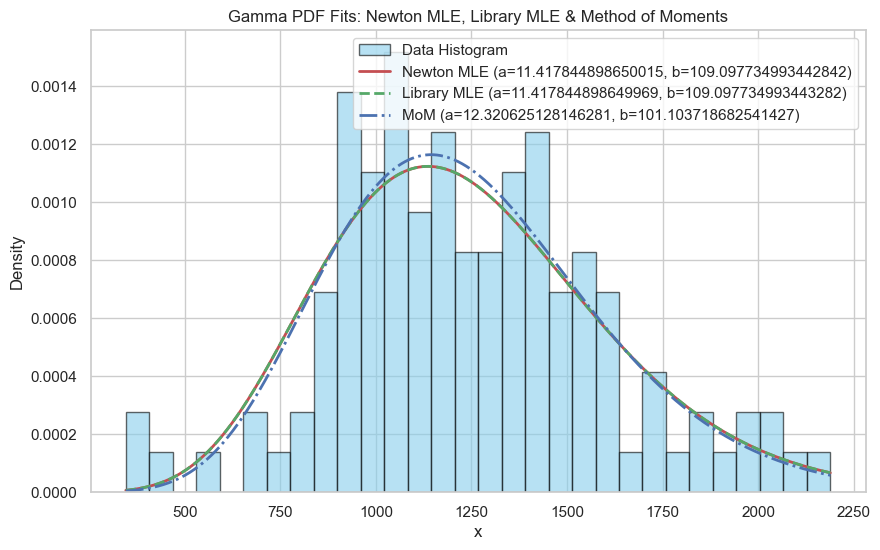

In [30]:
x_values = np.linspace(data.min(), data.max(), 1000)

# Computing Gamma PDFs using all three sets of estimates:
pdf_newt = stats.gamma.pdf(x_values, a_mle_newt, loc=0, scale=b_mle_newt)
pdf_lib = stats.gamma.pdf(x_values, a_mle_lib, loc=0, scale=b_mle_lib)
pdf_mom = stats.gamma.pdf(x_values, a_mom, loc=0, scale=b_mom)


plt.figure(figsize=(10, 6))
plt.hist(data, bins=30, density=True, alpha=0.6, color="skyblue", edgecolor="black", label="Data Histogram")


plt.plot(x_values, pdf_newt, 'r-', lw=2, 
         label="Newton MLE (a={:.15f}, b={:.15f})".format(a_mle_newt, b_mle_newt))
plt.plot(x_values, pdf_lib, 'g--', lw=2, 
         label="Library MLE (a={:.15f}, b={:.15f})".format(a_mle_lib, b_mle_lib))
plt.plot(x_values, pdf_mom, 'b-.', lw=2, 
         label="MoM (a={:.15f}, b={:.15f})".format(a_mom, b_mom))

plt.xlabel("x")
plt.ylabel("Density")
plt.title("Gamma PDF Fits: Newton MLE, Library MLE & Method of Moments")
plt.legend()
plt.show()


Note the library estimates and the Newton-Raphson method estimates are very close, hence their plots seem to coincide 

# PART 2

## Normal distribution Interval Estimation

Assume we have a random sample $X_1, X_2, \dots, X_n$ from a normal distribution $N(\mu, \sigma^2)$. The sample variance is defined as

$$
S^2 = \frac{1}{n-1} \sum_{i=1}^n (X_i - \bar{X})^2.
$$

A well-known result in statistics is that the statistic

$$
\frac{(n-1)S^2}{\sigma^2}
$$

follows a chi-square distribution with $n-1$ degrees of freedom:

$$
\frac{(n-1)S^2}{\sigma^2} \sim \chi^2_{n-1}.
$$

Let $\chi^2_{\alpha/2,\,n-1}$ and $\chi^2_{1-\alpha/2,\,n-1}$ denote the lower and upper $\alpha/2$ quantiles of the $\chi^2$ distribution with $n-1$ degrees of freedom. Then, by the definition of these quantiles, we have

$$
P\left(\chi^2_{1-\alpha/2,\,n-1} \le \frac{(n-1)S^2}{\sigma^2} \le \chi^2_{\alpha/2,\,n-1}\right) = 1 - \alpha.
$$

For a 95% confidence interval, set $\alpha = 0.05$ (so $\alpha/2 = 0.025$ and $1-\alpha/2 = 0.975$). Rearranging the inequality to solve for $\sigma^2$:

1. Multiply through by $\sigma^2$:

$$
P\left(\chi^2_{1-\alpha/2,\,n-1} \cdot \sigma^2 \le (n-1)S^2 \le \chi^2_{\alpha/2,\,n-1} \cdot \sigma^2\right) = 1 - \alpha.
$$

2. Divide through by the corresponding chi-square quantiles:

$$
P\left(\frac{(n-1)S^2}{\chi^2_{\alpha/2,\,n-1}} \ge \sigma^2 \ge \frac{(n-1)S^2}{\chi^2_{1-\alpha/2,\,n-1}}\right) = 1 - \alpha.
$$

Thus, the $1-\alpha$ confidence interval for $\sigma^2$ is

$$
\left(\frac{(n-1)S^2}{\chi^2_{\alpha/2,\,n-1}},\ \frac{(n-1)S^2}{\chi^2_{1-\alpha/2,\,n-1}}\right).
$$

For a 95% confidence interval, this becomes

$$
\left(\frac{(n-1)S^2}{\chi^2_{0.025,\,n-1}},\ \frac{(n-1)S^2}{\chi^2_{0.975,\,n-1}}\right).
$$

This completes the brief proof of the confidence interval formula for the variance of a normal distribution.

   where:
   - $n$ = number of observations (sample size).
   - $S^2$ = sample variance (using the unbiased estimator).
   - $\chi^2_{0.975}$ = 97.5th percentile of the chi-square distribution with (n - 1) degrees of freedom.
   - $\chi^2_{0.025}$  = 2.5th percentile of the chi-square distribution with (n - 1) degrees of freedom.

In [35]:
n = len(df)
print("Number of observations (n):", n)


sample_variance = df['Rating'].var(ddof=1)
print("Sample Variance (S^2):", sample_variance)


df_degrees = n - 1


alpha = 0.05
#for ppf if we need chi^2(x), we need to give chi^2(1-x) (defined like that)
chi2_lower = stats.chi2.ppf(1-alpha/2, df_degrees) 
chi2_upper = stats.chi2.ppf((alpha/2), df_degrees)        

print("Chi-square critical value (upper):", chi2_upper)
print("Chi-square critical value (lower):", chi2_lower)

# Computing the confidence interval for the variance
lower_bound = (df_degrees * sample_variance) / chi2_lower
upper_bound = (df_degrees * sample_variance) / chi2_upper

print("\nThe 95% confidence interval for the variance is:")
print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)

Number of observations (n): 118
Sample Variance (S^2): 125940.9610314356
Chi-square critical value (upper): 88.95509049017204
Chi-square critical value (lower): 148.8288363128863

The 95% confidence interval for the variance is:
Lower Bound: 99006.97207428297
Upper Bound: 165646.42180096408


# PART 3

### We have a dataset that contains information on the number of hours of sleep recorded for individuals, along with their gender.  
### It consists of two distinct populations: males and females, whose sleep durations are analyzed separately. We will be using these two non-overlapping populations to model them as independent normal distributions with unknown means and variances and compute the 95% confidence interval for the difference in the means of the two populations.



## Required Formula and Derivation

Let two independent random samples be as follows:

- $ X_1, X_2, \dots, X_n \sim \mathcal{N}(\mu_1, \sigma^2) $ (in this case, sleep hours for males)
- $Y_1, Y_2, \dots, Y_m \sim \mathcal{N}(\mu_2, \sigma^2)$ (in this case, sleep hours for females)

We aim to estimate the difference in population means, $(\mu_1 - \mu_2)$, and construct a 95% confidence interval.

The sample mean and sample variances are as follows:
$$
\bar{X} = \frac{1}{n} \sum_{i=1}^{n} X_i
$$

$$
\bar{Y} = \frac{1}{m} \sum_{j=1}^{m} Y_j
$$

$$
S_1^2 = \frac{1}{n-1} \sum_{i=1}^{n} (X_i - \bar{X})^2
$$

$$
S_2^2 = \frac{1}{m-1} \sum_{j=1}^{m} (Y_j - \bar{Y})^2
$$
We know that, assuming normal distribution we get:
$$
\frac{(n-1)S_1^2}{\sigma^2} \sim \chi^2_{n-1}, \qquad
\frac{(m-1)S_2^2}{\sigma^2} \sim \chi^2_{m-1}.
$$

Because the samples are independent, the sum of these independent chi-square variables is also chi-square distributed:
$$
\frac{(n-1)S_1^2 + (m-1)S_2^2}{\sigma^2} \sim \chi^2_{n+m-2}.
$$

Assuming the populations are normal and the population variances are equal, we estimate it using the pooled variance:
$$
S_p^2 = \frac{(n-1)S_1^2 + (m-1)S_2^2}{n + m - 2}.
$$

The difference in sample means $\bar{X} - \bar{Y}$ is normally distributed:
$$
\bar{X} - \bar{Y} \sim \mathcal{N} \left( \mu_1 - \mu_2, \ \sigma^2\left(\frac{1}{n} + \frac{1}{m}\right) \right).
$$

Replacing $\sigma^2$ with the estimator $S_p^2$, the standardized form becomes a $t$-statistic:
$$
T = \frac{(\bar{X} - \bar{Y}) - (\mu_1 - \mu_2)}{S_p \sqrt{\frac{1}{n} + \frac{1}{m}}} \sim t_{n+m-2}.
$$

By properties of the $t$-distribution:
$$
P\left( -t_{\alpha/2,\,n+m-2} \le \frac{(\bar{X} - \bar{Y}) - (\mu_1 - \mu_2)}{S_p \sqrt{\frac{1}{n} + \frac{1}{m}}} \le t_{\alpha/2,\,n+m-2} \right) = 1 - \alpha.
$$

Rearranging gives the $100(1 - \alpha)%$ confidence interval for $\mu_1 - \mu_2$:
$$
\left( (\bar{X} - \bar{Y}) - t_{\alpha/2,\,n+m-2} S_p \sqrt{\frac{1}{n} + \frac{1}{m}}, \quad
       (\bar{X} - \bar{Y}) + t_{\alpha/2,\,n+m-2} S_p \sqrt{\frac{1}{n} + \frac{1}{m}} \right).
$$

Then the 95\% confidence interval for $\mu_1 - \mu_2$ is given by:


$$
\text{CI}_{95\%} = (\bar{X} - \bar{Y}) \pm t_{0.025, n+m-2} \cdot S_p \sqrt{\frac{1}{n} + \frac{1}{m}}
$$

Here,
- $n, m$ are the sample sizes
- $S_1^2, S_2^2$ are the sample variances
- $S_p^2$ is the pooled estimate of the variance
- $t_{\alpha/2, n+m-2}$ is the critical value from the t-distribution

This formula assumes:
- The populations are normally distributed
- The samples are independent
- The population variances are equal



## Understanding the Dataset

In [41]:
df = pd.read_csv("Sleep_Efficiency.csv")
display(HTML(df.head().to_html()))
display(HTML(pd.DataFrame(df.dtypes).to_html()))

,ID,Age,Gender,Bedtime,Wakeup time,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
0,1,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,12,0.0,0.0,0.0,Yes,3.0
1,2,69,Male,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,0.66,19,28,53,3.0,0.0,3.0,Yes,3.0
2,3,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,No,3.0
3,4,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,23,25,52,3.0,50.0,5.0,Yes,1.0
4,5,57,Male,2021-03-13 01:00:00,2021-03-13 09:00:00,8.0,0.76,27,55,18,3.0,0.0,3.0,No,3.0


,0
ID,int64
Age,int64
Gender,object
Bedtime,object
Wakeup time,object
Sleep duration,float64
Sleep efficiency,float64
REM sleep percentage,int64
Deep sleep percentage,int64
Light sleep percentage,int64


The dataset is as above. We will be focusing only on "Sleep duration" data of males and females- forming two related non-overlapping populations.

In [43]:
# Group by gender
male_sleep = df[df['Gender'] == 'Male']['Sleep duration'].values
female_sleep = df[df['Gender'] == 'Female']['Sleep duration'].values

# Sample sizes
n, m = len(male_sleep), len(female_sleep)
print(n, m)

228 224


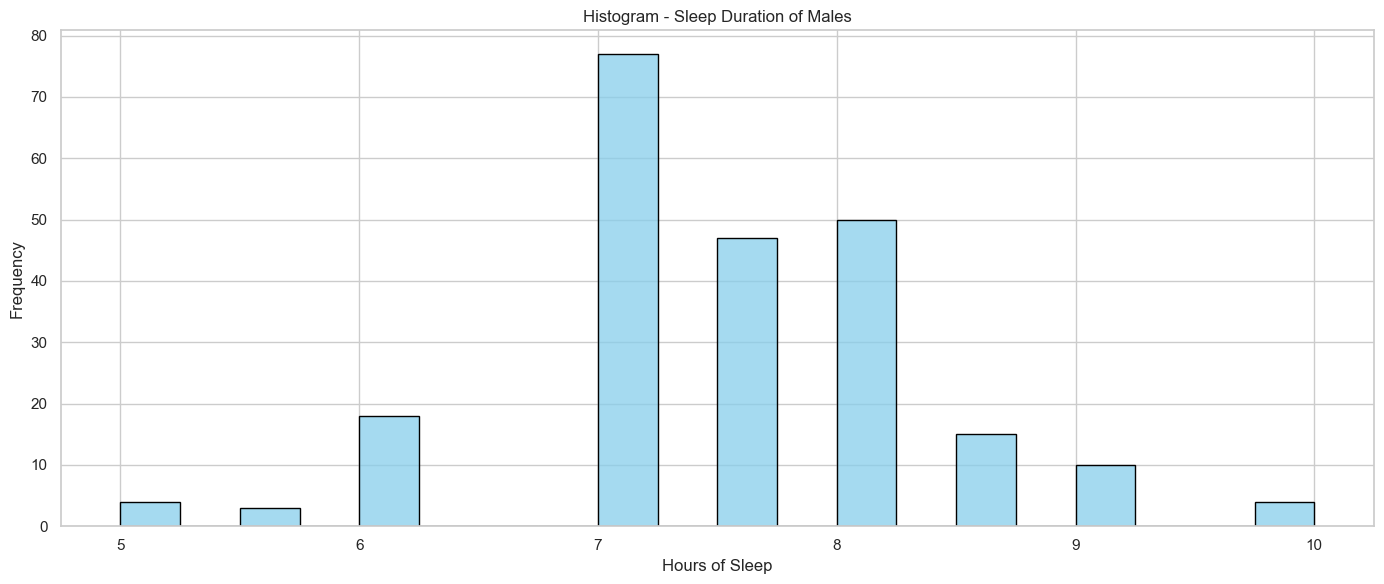

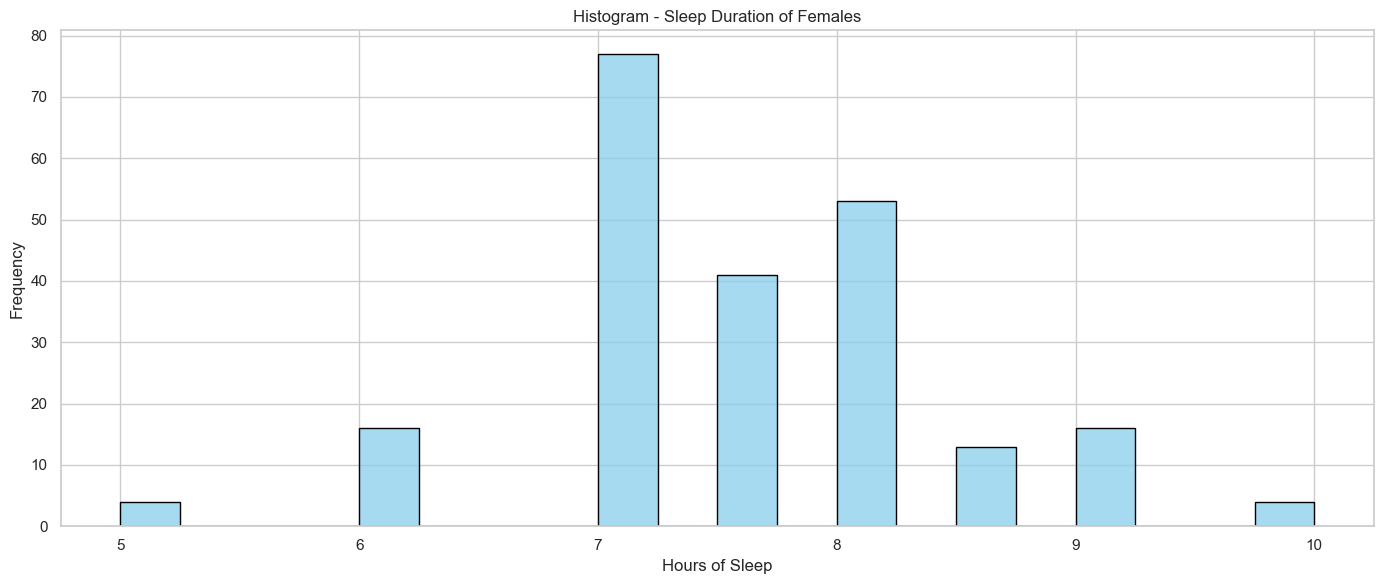

In [44]:
# Assuming df is your DataFrame and 'Sleep Duration' is the column
male_sleep_df = df[df['Gender'] == 'Male']['Sleep duration']
female_sleep_df = df[df['Gender'] == 'Female']['Sleep duration']

# Histogram plots
plt.figure(figsize=(14, 6))
sns.histplot(male_sleep_df, kde=False, bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram - Sleep Duration of Males")
plt.xlabel("Hours of Sleep")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.histplot(female_sleep_df, kde=False, bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram - Sleep Duration of Females")
plt.xlabel("Hours of Sleep")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


The above graphs represent distribution of sleep durations in males and females from the given dataset.

## 95% Confidence Interval for the Difference in Means
Assuming the distributions to be normal, samples to be independent and population variances to be equal, the required interval- 95% confidence interval for the difference in the means of the two populations- is computed as follows using the formula derivation explained above.

In [47]:
# Sample means and variances
mean_m, mean_f = np.mean(male_sleep), np.mean(female_sleep)
s1_sq = np.var(male_sleep, ddof=1)
s2_sq = np.var(female_sleep, ddof=1)

# Pooled variance
pooled_var = (((n - 1) * s1_sq) + ((m - 1) * s2_sq)) / (n + m - 2)

# Standard error
se = np.sqrt((1/n + 1/m) * pooled_var)

# Degrees of freedom 
dfree = n + m - 2

# t-critical value
alpha = 0.05 # for 95% confidence interval
# For ppf: For t(a), we need to input (1-a) as it is defined that way
t_crit = stats.t.ppf(1-alpha/2, dfree)

# Confidence interval
diff = mean_m - mean_f
ci_lower = diff - t_crit * se
ci_upper = diff + t_crit * se
print("The boundary limits of the required interval is as follows:")
print(ci_lower, ci_upper)

The boundary limits of the required interval is as follows:
-0.2370762962272181 0.0834108826933832


In [48]:
# Print results
print(f"Sample Mean Sleep (Males): {mean_m:.2f} hrs")
print(f"Sample Mean Sleep (Females): {mean_f:.2f} hrs")
print(f"95% CI for (Male - Female) Mean Sleep [Equal Variances]: ({ci_lower:.2f}, {ci_upper:.2f}) hrs")

Sample Mean Sleep (Males): 7.43 hrs
Sample Mean Sleep (Females): 7.50 hrs
95% CI for (Male - Female) Mean Sleep [Equal Variances]: (-0.24, 0.08) hrs


### Therefore, the 95% confidence interval for the difference in the means of the two populations (sleep durations of males, sleep duration of females) is given by: (-0.24, 0.08) hrs.

# PART 4

## Testing Daily Sign Agreement Between BTC and ETH Returns (2019–2023)

### Introduction

This section explores whether the daily **log returns** of Bitcoin (BTC) and Ethereum (ETH) exhibit a tendency to move in the **same direction** over a five-year period (2019–2023).

#### Objective:
We define a binary signal:
- `1` if BTC and ETH had log returns of the same sign (both positive or both negative)
- `0` if their signs differed

We then test whether the probability of this agreement (signal = 1) is **greater than 0.5** using a hypothesis test.

#### Hypothesis:
- **Null Hypothesis ($H_0$)**: $p \leq 0.5$  
- **Alternative Hypothesis ($H_1$)**: $p > 0.5$

We assume the signals $X_i \sim \text{Bernoulli}(p)$ are i.i.d., and apply a **normal approximation to the binomial** for computing the p-value.

---


In [52]:
# Load data
btc_df = pd.read_csv('BTC_2019_2023_1d.csv', index_col=0)
eth_df = pd.read_csv('ETHUSDT_1d.csv', index_col=0)

print("The first 5 rows of the BTC dataset: ")
display(HTML(btc_df.head().to_html()))
print("The first 5 rows of the ETH dataset: ")
display(HTML(eth_df.head().to_html()))

print("The datatypes of each feature of the BTC dataset: ")
display(HTML(pd.DataFrame(btc_df.dtypes).to_html()))

The first 5 rows of the BTC dataset: 


,datetime,open,high,low,close,volume
0,2019-09-08,10000.00,10412.65,10000.00,10391.63,3096.291
1,2019-09-09,10316.62,10475.54,10077.22,10307.00,14824.373
2,2019-09-10,10307.00,10382.97,9940.87,10102.02,9068.955
3,2019-09-11,10094.27,10293.11,9884.31,10159.55,10897.922
4,2019-09-12,10163.06,10450.13,10042.12,10415.13,15609.634


The first 5 rows of the ETH dataset: 


,datetime,open,high,low,close,volume
0,2019-12-01,151.38,152.50,145.50,150.65,394494.119
1,2019-12-02,150.72,151.30,146.67,148.59,395630.910
2,2019-12-03,148.59,149.80,145.62,147.10,495996.573
3,2019-12-04,147.12,152.22,142.96,145.35,684404.817
4,2019-12-05,145.36,148.88,143.77,148.04,441113.912


The datatypes of each feature of the BTC dataset: 


,0
datetime,object
open,float64
high,float64
low,float64
close,float64
volume,float64


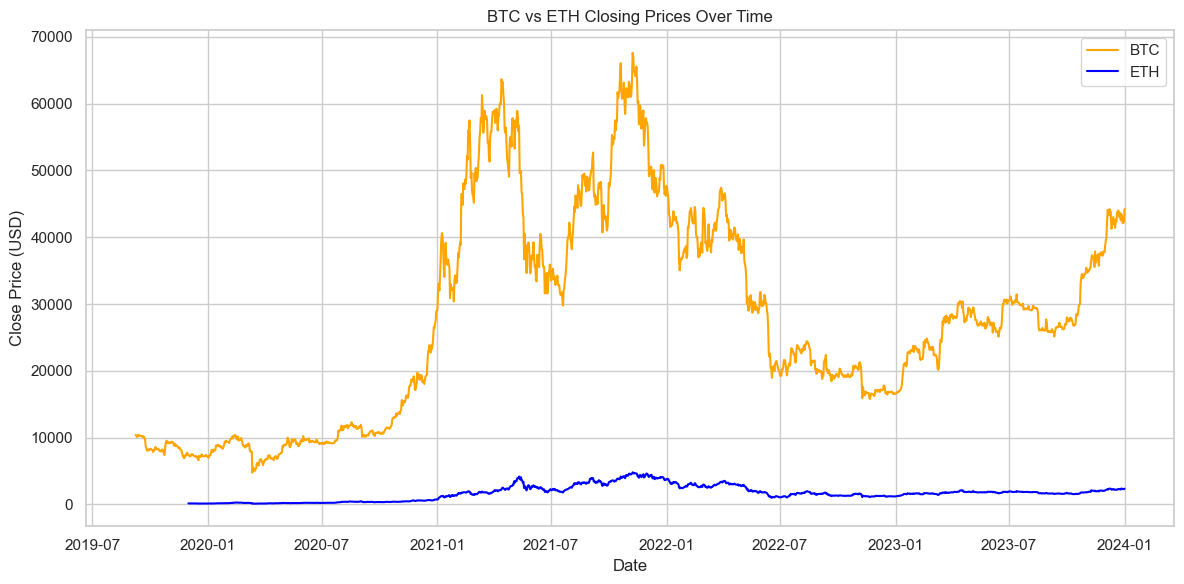

In [53]:
# Parse datetime
btc_df['datetime'] = pd.to_datetime(btc_df['datetime'])
eth_df['datetime'] = pd.to_datetime(eth_df['datetime'])

# Sort by time
btc_df = btc_df.sort_values('datetime')
eth_df = eth_df.sort_values('datetime')

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(btc_df['datetime'], btc_df['close'], label='BTC', color='orange')
plt.plot(eth_df['datetime'], eth_df['close'], label='ETH', color='blue')

plt.title('BTC vs ETH Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
# We rename the columns so that there's no ambiguity when we merge
btc_df = btc_df.rename(columns={'close': 'btc_close'})
eth_df = eth_df.rename(columns={'close': 'eth_close'})

# Merge on datetime
df = pd.merge(btc_df[['datetime', 'btc_close']], eth_df[['datetime', 'eth_close']], on='datetime')
# An inner join is done by default, so we don't need to worry about non-matching datetime columns

display(HTML(df.head().to_html()))
display(HTML(df.describe().to_html()))

,datetime,btc_close,eth_close
0,2019-12-01,7387.38,150.65
1,2019-12-02,7291.00,148.59
2,2019-12-03,7290.86,147.10
3,2019-12-04,7191.00,145.35
4,2019-12-05,7384.99,148.04


,datetime,btc_close,eth_close
count,1493,1493.000000,1493.000000
mean,2021-12-16 00:00:00.000000256,28436.050288,1683.189585
min,2019-12-01 00:00:00,4764.650000,106.710000
25%,2020-12-08 00:00:00,16667.200000,590.910000
50%,2021-12-16 00:00:00,27089.500000,1661.950000
75%,2022-12-24 00:00:00,39498.920000,2235.320000
max,2024-01-01 00:00:00,67606.960000,4814.300000
std,NaN,15267.299098,1119.315769


> Note: I did a check for empty rows, there's nothing in either dataset.

### Log Returns and Signal Generation

We compute daily log returns for BTC and ETH, and then create a signal based on whether both assets moved in the same direction.

In [57]:
df['btc_log_return'] = np.log(df['btc_close']/df['btc_close'].shift(1))
df['eth_log_return'] = np.log(df['eth_close']/df['eth_close'].shift(1))
df = df.dropna(subset=['btc_log_return', 'eth_log_return'])
# We're only removing the very first row

display(HTML(df.head().to_html()))
display(HTML(df.describe().to_html()))

,datetime,btc_close,eth_close,btc_log_return,eth_log_return
1,2019-12-02,7291.00,148.59,-0.013132,-0.013768
2,2019-12-03,7290.86,147.10,-0.000019,-0.010078
3,2019-12-04,7191.00,145.35,-0.013791,-0.011968
4,2019-12-05,7384.99,148.04,0.026619,0.018338
5,2019-12-06,7522.10,148.41,0.018396,0.002496


,datetime,btc_close,eth_close,btc_log_return,eth_log_return
count,1492,1492.000000,1492.000000,1492.000000,1492.000000
mean,2021-12-16 12:00:00,28450.157976,1684.216756,0.001199,0.001843
min,2019-12-02 00:00:00,4764.650000,106.710000,-0.510486,-0.601910
25%,2020-12-08 18:00:00,16678.375000,591.607500,-0.013327,-0.018104
50%,2021-12-16 12:00:00,27095.950000,1662.390000,0.000480,0.001598
75%,2022-12-24 06:00:00,39500.590000,2236.827500,0.016643,0.023983
max,2024-01-01 00:00:00,67606.960000,4814.300000,0.178716,0.234909
std,NaN,15262.680203,1118.986946,0.036261,0.047357


In [58]:
df.loc[df['btc_log_return'] * df['eth_log_return'] > 0, 'signal'] = 1
df.loc[df['btc_log_return'] * df['eth_log_return'] <= 0, 'signal'] = 0

display(HTML(df.head().to_html()))
display(HTML(df.tail().to_html()))

,datetime,btc_close,eth_close,btc_log_return,eth_log_return,signal
1,2019-12-02,7291.00,148.59,-0.013132,-0.013768,1.0
2,2019-12-03,7290.86,147.10,-0.000019,-0.010078,1.0
3,2019-12-04,7191.00,145.35,-0.013791,-0.011968,1.0
4,2019-12-05,7384.99,148.04,0.026619,0.018338,1.0
5,2019-12-06,7522.10,148.41,0.018396,0.002496,1.0


,datetime,btc_close,eth_close,btc_log_return,eth_log_return,signal
1488,2023-12-28,42600.1,2345.96,-0.019842,-0.014536,1.0
1489,2023-12-29,42095.1,2300.60,-0.011925,-0.019525,1.0
1490,2023-12-30,42174.2,2293.26,0.001877,-0.003196,0.0
1491,2023-12-31,42314.0,2283.85,0.003309,-0.004112,0.0
1492,2024-01-01,44230.2,2354.62,0.044290,0.030517,1.0


In [59]:
# Count outcomes
signal_counts = df['signal'].value_counts()
num_successes = signal_counts[1.0]
n = signal_counts.sum()

print(f"Total observations (n): {n}")
print(f"Number of same-sign days (successes): {num_successes}")
print(f"Empirical proportion: {num_successes/n:.4f}")

Total observations (n): 1492
Number of same-sign days (successes): 1245
Empirical proportion: 0.8345


### Hypothesis Explanation

We aim to test the hypothesis that **BTC and ETH tend to move in the same direction more often than not**. Our binary variable `signal` captures this relationship on a daily level:

- `signal = 1` if BTC and ETH log returns have the **same sign** (both positive or both negative)
- `signal = 0` if they have **opposite signs**

This signal gives a sense of **directional correlation**, but it does not quantify the strength or magnitude of the movement.

#### Hypotheses

Let $ p $ be the true probability that the BTC and ETH log returns have the same sign on any given day. Then:

- **Null Hypothesis $ H_0 $**: $ p \leq 0.5 $  
- **Alternative Hypothesis $ H_1 $**: $ p > 0.5 $

This test seeks to determine whether there is **statistical evidence that the probability of directional agreement exceeds 50%**, indicating a stronger-than-chance co-movement.

#### Assumptions

To proceed with the test, we make the following assumptions:

1. Each day’s signal is **independent** of the others, i.e., knowing the co-movement on one day does not inform us about another.
2. The probability $ p $ of agreement remains **constant** across the time period.
3. Since the number of observations is large ($ n = 1491 $), we use the **normal approximation to the binomial distribution** for inference.

#### Statistical Model

Let $ X_i $ be an indicator random variable where:

$$X_i = 
\begin{cases}
1, & \text{if BTC and ETH moved in the same direction on day } i \\
0, & \text{otherwise}
\end{cases}$$

Then $ X = \sum_{i=1}^n X_i \sim \text{Binomial}(n, p) $, where $ X $ is the total number of days with the same directional movement, and $ n = 1491 $ is the total number of trading days in the sample.

Under the null hypothesis $ H_0: p = 0.5 $, we approximate the binomial distribution using the **normal distribution**:

- Mean $ \mu = np = 1491 \times 0.5 = 745.5 $
- Standard deviation $ \sigma = \sqrt{np(1 - p)} = \sqrt{1491 \times 0.5 \times 0.5} \approx 19.32 $

Let $ X_{\text{obs}} = 1245 $ be the observed number of days when BTC and ETH had the same sign.

We compute the standardized test statistic:

$$Z = \frac{X_{\text{obs}} - \mu}{\sigma}$$

We then calculate the **one-sided p-value**:

$$P(Z \geq \text{observed}) = 1 - \Phi(Z)$$

#### Decision Rule

At a 5% level of significance:

- If $ p\text{-value} < 0.05 $: **Reject** the null hypothesis — there's sufficient evidence to claim BTC and ETH tend to move in the same direction more than half the time.
- If $ p\text{-value} \geq 0.05 $: **Fail to reject** the null — no statistically significant evidence of stronger-than-random co-movement.


### Hypothesis Testing

We use the **Normal approximation to the Binomial distribution** for large-sample inference:

Let $ X = \sum X_i \sim \text{Binomial}(n, p) $. Under the null hypothesis $ H_0: p = 0.5 $, we compute:

- $ \mu = np $
- $ \sigma = \sqrt{np(1 - p)} $
- $ Z = \frac{X - \mu}{\sigma} $

We calculate the **one-tailed p-value**:
$$P(Z \geq \text{observed}) = 1 - \Phi(z)$$


In [62]:
# Parameters under H0
p0 = 0.5
mu = n * p0
sigma = np.sqrt(n * p0 * (1 - p0))

# Z-score
z = (num_successes - mu) / sigma

# One-sided p-value
p_value = 1 - norm.cdf(z)

print(f"Z-score: {z:.4f}")
print(f"One-sided p-value: {p_value:.6f}")

Z-score: 25.8372
One-sided p-value: 0.000000


### Conclusion
We reject the null hypothesis at the 5% significance level. There is statistical evidence that BTC and ETH move in the same direction more than half the time.

#### Visualizing the Signal Distribution

A simple bar chart showing how many times BTC and ETH had returns of the same vs. opposite signs.

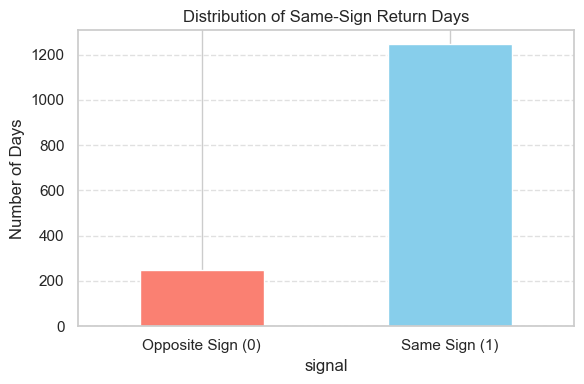

In [65]:
plt.figure(figsize=(6, 4))
df['signal'].value_counts().sort_index().plot(kind='bar', color=['salmon', 'skyblue'])
plt.xticks([0, 1], ['Opposite Sign (0)', 'Same Sign (1)'], rotation=0)
plt.title('Distribution of Same-Sign Return Days')
plt.ylabel('Number of Days')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Thank you for reading our assignment till the end :)**

Written by Ankita Sri S P, Siddarth and Faheem. \
MA23BTECH11001, MA23BTECH11017, MA23BTECH11010 respectively.